In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [2]:
wildfires = pd.read_csv('Historical_wildfires.csv')
wildfires['Date'] = pd.to_datetime(wildfires['Date'])
wildfires = pd.pivot(wildfires, index = 'Date', columns = 'Region', values = 'Estimated_fire_area')
wildfires.reset_index(inplace=True)
print('# of rows must equal :', len(pd.date_range(start = '2005-01-01', end = '2020-10-31')))
wildfires


# Instantiating another dataframe with a daterange and merge to find the missing date.
dummy = pd.DataFrame()
dummy['Date'] = pd.date_range(start = '2005-01-01', end = '2020-10-31')

# 2020-03-06 have missing values for all 7 states.
wildfires = pd.merge(wildfires, dummy, how = 'outer')
wildfires.set_index('Date', inplace=True)
wildfires.sort_index(inplace=True)


wildfires.fillna(0, inplace = True)

columns = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
wildfires

# of rows must equal : 5783


,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2005-01-01,0.00000,4.945000,38.831579,0.0,0.0,0.0,36.382500
2005-01-02,0.00000,1.320000,64.464286,0.0,0.0,2.8,148.106471
2005-01-03,0.00000,88.740000,47.386585,0.0,0.0,1.0,60.632258
2005-01-04,8.68000,0.000000,30.100000,0.0,0.0,0.0,86.374167
2005-01-05,16.61125,0.000000,4.000000,0.0,0.0,0.0,31.378947
...,...,...,...,...,...,...,...
2020-10-27,1.21000,12.750000,78.670769,0.0,0.0,0.0,32.970000
2020-10-28,3.00000,144.990566,119.608649,0.0,0.0,2.0,20.840625
2020-10-29,0.00000,53.462326,249.090625,0.0,0.0,0.0,136.083077


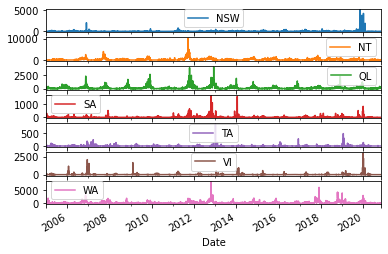

In [3]:
wildfires.plot(subplots=True);

In [33]:
df = wildfires.copy(deep=True)
df = np.log1p(df)

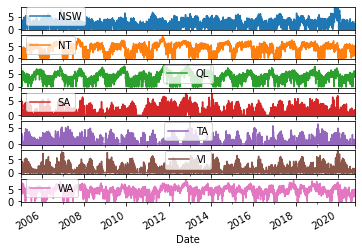

In [34]:
df.plot(subplots=True);

In [35]:
train = df[:'2019-10-31']
test = df['2019-11-01':'2020-03-02']

In [36]:
test.shape

(123, 7)

In [37]:

tf.keras.backend.clear_session()

In [38]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5417, 7)

In [39]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [40]:
n_steps_in, n_steps_out = 365, 123

In [41]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(4930, 123, 7)

In [42]:
X.shape

(4930, 365, 7)

In [43]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [44]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [45]:
y.shape

(4930, 861)

In [46]:
n_output

861

In [47]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss='mean_squared_error', metrics = ['mae'])

In [48]:
history = model.fit(X, y, epochs = 100, callbacks = [lr_schedule], validation_split= 0.2)

Epoch 1/100
124/124 [==============================] - 11s 89ms/step - loss: 0.1392 - mae: 0.2795 - val_loss: 0.1439 - val_mae: 0.2843
Epoch 2/100
124/124 [==============================] - 9s 75ms/step - loss: 0.1377 - mae: 0.2784 - val_loss: 0.1410 - val_mae: 0.2822
Epoch 3/100
124/124 [==============================] - 9s 75ms/step - loss: 0.1348 - mae: 0.2762 - val_loss: 0.1365 - val_mae: 0.2787
Epoch 4/100
124/124 [==============================] - 9s 75ms/step - loss: 0.1302 - mae: 0.2725 - val_loss: 0.1303 - val_mae: 0.2737
Epoch 5/100
124/124 [==============================] - 9s 75ms/step - loss: 0.1237 - mae: 0.2669 - val_loss: 0.1221 - val_mae: 0.2665
Epoch 6/100
124/124 [==============================] - 9s 75ms/step - loss: 0.1153 - mae: 0.2591 - val_loss: 0.1121 - val_mae: 0.2567
Epoch 7/100
124/124 [==============================] - 9s 75ms/step - loss: 0.1049 - mae: 0.2484 - val_loss: 0.1001 - val_mae: 0.2437
Epoch 8/100
124/124 [==============================] - 9s 75m

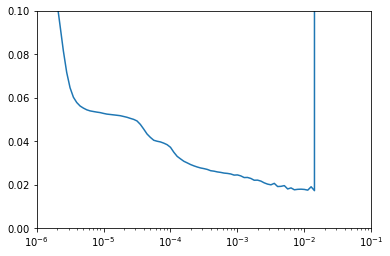

In [51]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, .1]);

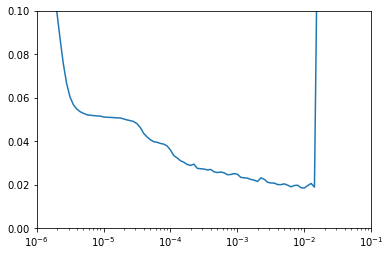

In [52]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, .1]);

In [53]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-4)

# model.compile(SGD(lr = 0.1, momentum = 0.8, decay = 0.1 / 20), loss='mean_absolute_error')
model.compile(optimizer, loss='mean_squared_error', metrics = ['mae'])

In [54]:
history = model.fit(X, y, epochs = 100, validation_split= 0.2)

Epoch 1/100
124/124 [==============================] - 11s 89ms/step - loss: 0.0690 - mae: 0.1927 - val_loss: 0.0573 - val_mae: 0.1764
Epoch 2/100
124/124 [==============================] - 9s 74ms/step - loss: 0.0574 - mae: 0.1762 - val_loss: 0.0563 - val_mae: 0.1743
Epoch 3/100
124/124 [==============================] - 9s 75ms/step - loss: 0.0562 - mae: 0.1736 - val_loss: 0.0550 - val_mae: 0.1694
Epoch 4/100
124/124 [==============================] - 9s 75ms/step - loss: 0.0532 - mae: 0.1665 - val_loss: 0.0503 - val_mae: 0.1602
Epoch 5/100
124/124 [==============================] - 9s 75ms/step - loss: 0.0485 - mae: 0.1574 - val_loss: 0.0463 - val_mae: 0.1527
Epoch 6/100
124/124 [==============================] - 9s 75ms/step - loss: 0.0455 - mae: 0.1520 - val_loss: 0.0446 - val_mae: 0.1506
Epoch 7/100
124/124 [==============================] - 9s 75ms/step - loss: 0.0436 - mae: 0.1487 - val_loss: 0.0426 - val_mae: 0.1464
Epoch 8/100
124/124 [==============================] - 9s 75m

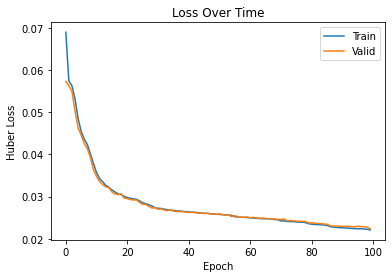

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [56]:
x_input = np.array(train.iloc[-365:].values)
x_input = scaler.transform(x_input)

In [57]:
x_input = x_input.reshape((1, n_steps_in, n_features))

In [58]:
yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 861)

In [59]:
yhat_df = pd.DataFrame(yhat.reshape(123,7), index = test.index, columns = columns)

In [60]:
yhat_df

,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2019-11-01,0.233589,0.742215,0.721091,0.242940,0.060458,0.086963,0.758831
2019-11-02,0.247101,0.775238,0.720272,0.240547,0.096042,0.036246,0.739401
2019-11-03,0.247222,0.783492,0.738617,0.240827,0.047793,0.062944,0.739498
2019-11-04,0.226300,0.757477,0.712765,0.249966,0.084780,0.050595,0.739380
2019-11-05,0.219035,0.770774,0.748478,0.230218,0.121973,0.013567,0.712973
...,...,...,...,...,...,...,...
2020-02-27,0.364972,0.330480,0.358196,0.310078,0.073261,0.240647,0.537432
2020-02-28,0.382730,0.280270,0.366250,0.274925,0.102161,0.181640,0.533642
2020-02-29,0.344771,0.258357,0.357253,0.220581,0.084077,0.171189,0.517578


In [61]:
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [62]:
yhat_df

,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2019-11-01,1.782151,6.845047,5.962443,1.801140,0.406272,0.664363,6.861499
2019-11-02,1.885242,7.149602,5.955671,1.783400,0.645402,0.276904,6.685802
2019-11-03,1.886165,7.225726,6.107358,1.785478,0.321168,0.480866,6.686687
2019-11-04,1.726544,6.985797,5.893604,1.853233,0.569720,0.386526,6.685612
2019-11-05,1.671112,7.108430,6.188899,1.706823,0.819654,0.103649,6.446838
...,...,...,...,...,...,...,...
2020-02-27,2.784528,3.047838,2.961795,2.298902,0.492309,1.838436,4.859562
2020-02-28,2.920010,2.584780,3.028389,2.038277,0.686515,1.387652,4.825297
2020-02-29,2.630409,2.382689,2.953995,1.635371,0.564991,1.307811,4.680040


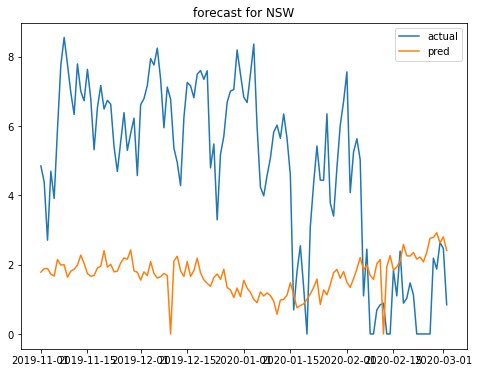

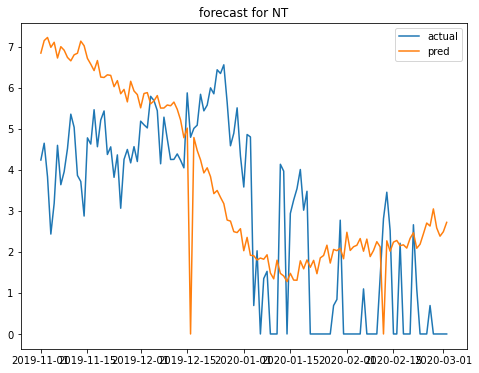

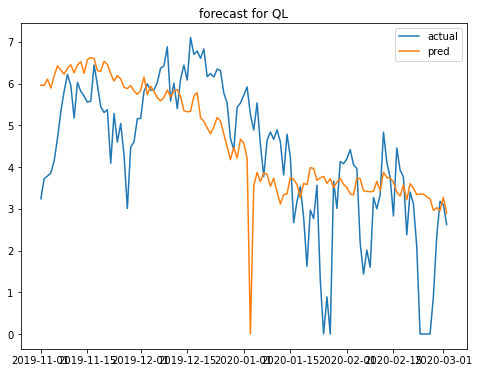

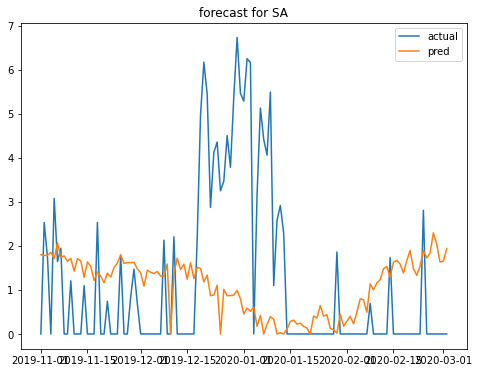

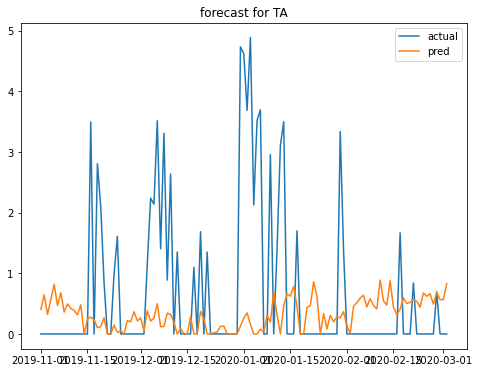

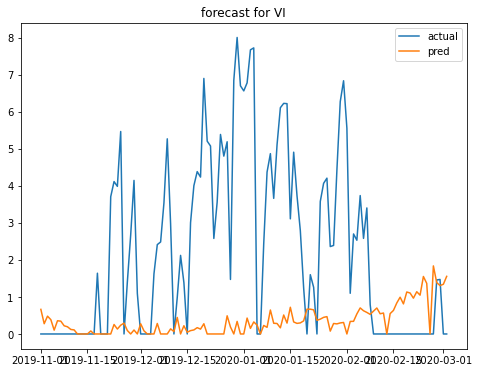

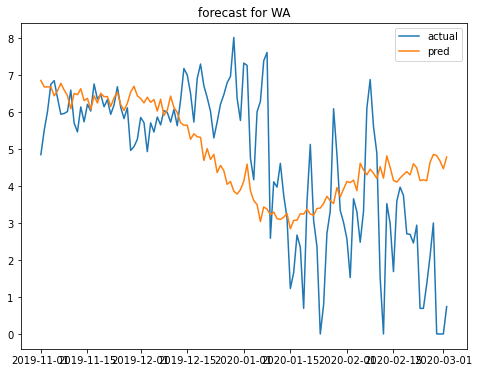

In [63]:
for i in yhat_df.columns:
    plt.figure(figsize=(8,6))
    plt.plot(test[i][:'2020-03'], label = 'actual')
    plt.plot(yhat_df[i][:'2020-03'], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

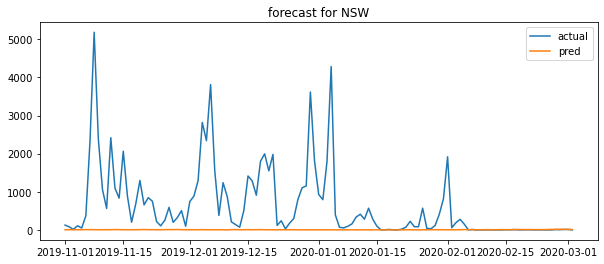

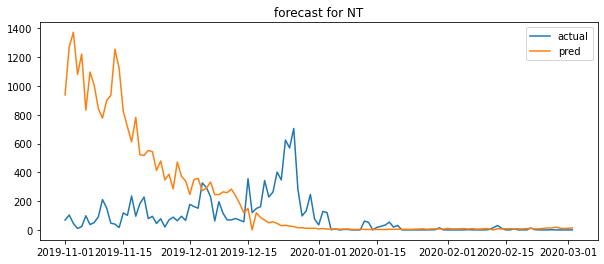

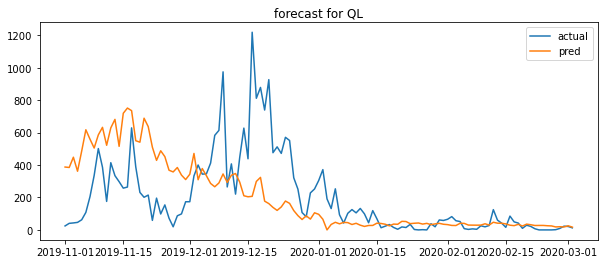

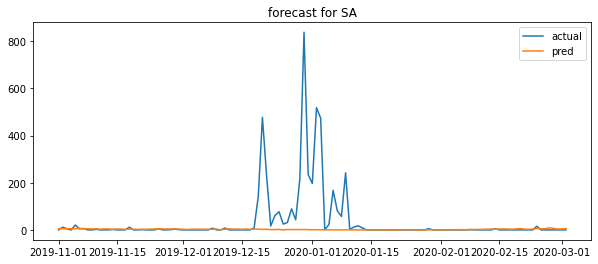

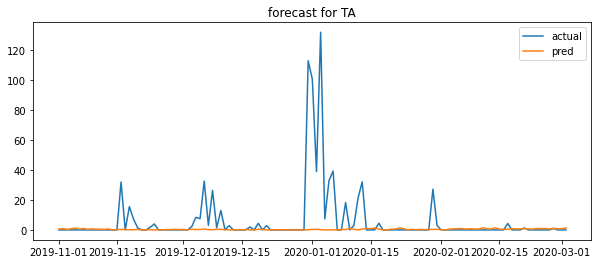

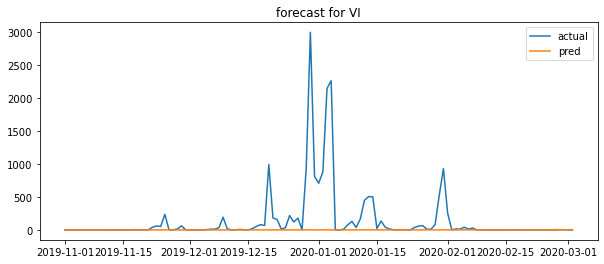

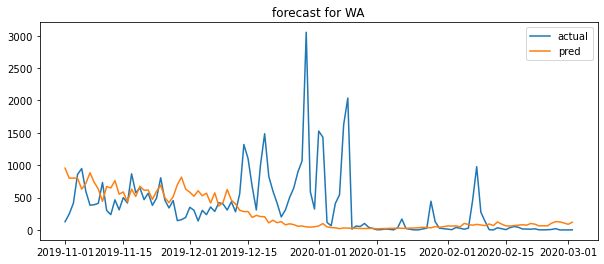

In [64]:
for i in columns:
    plt.figure(figsize=(10,4))
    plt.plot(np.exp(test[i][:'2020-03']) - 1, label = 'actual')
    plt.plot(np.exp(yhat_df[i][:'2020-03']) - 1, label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();